참조 링크 : https://github.com/qjadud1994/CRNN-Keras

# Build model

## [CTC loss](https://m.blog.naver.com/PostView.nhn?blogId=sogangori&logNo=221183469708&proxyReferer=https%3A%2F%2Fwww.google.com%2F)
> CTC는 학습데이터에 클래스 라벨만 순서대로 있고 각 클래스의 위치는 어디있는지 모르는 unsegmented 시퀀스 데이터의 학습을 위해서 사용하는 알고리즘

![image](https://user-images.githubusercontent.com/28910538/59762917-4bdc6300-92d3-11e9-9d54-31c6c63ae3a0.png)
- RNN은 시퀀스 데이터에대한 학습이 용이함
- 그 대신 각 노드에 대한 segmantation이 잘되어있어야함
- 근데 이런 segmatation을 해주지 않은 unsegmentated data에 대해서도 학습을 잘 시킬 수 있는 방법은 CTC(Connectionist Temporal Classification)알고리즘을 사용하도록 함

In [1]:
CHAR_VECTOR = "adefghjknqrstwABCDEFGHIJKLMNOPZ0123456789"
# one-hot으로 쓰기위한 letters 

letters = [letter for letter in CHAR_VECTOR]

num_classes = len(letters) + 1

img_w, img_h = 128, 64

# Network parameters
# batch_size = 128
# val_batch_size = 16
batch_size = 1
val_batch_size = 1

downsample_factor = 4
max_text_len = 9

In [2]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
K.set_learning_phase(0)

# # Loss and train functions, network architecture
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def get_Model(training):
    input_shape = (img_w, img_h, 1)     # (128, 64, 1)

    # Make Networkw
    inputs = Input(name='the_input', shape=input_shape, dtype='float32')  # (None, 128, 64, 1)

    # Convolution layer (VGG)
    inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  # (None, 128, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

    inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)

    inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)  # (None, 32, 8, 256)

    inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)  # (None, 32, 4, 512)

    inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 32, 4, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((32, 2048)), name='reshape')(inner)  # (None, 32, 2048)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

    # RNN layer
    lstm_1 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm1')(inner)  # (None, 32, 512)
    lstm_1b = LSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(inner)
    reversed_lstm_1b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)

    lstm1_merged = add([lstm_1, reversed_lstm_1b])  # (None, 32, 512)
    lstm1_merged = BatchNormalization()(lstm1_merged)
    
    lstm_2 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = LSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    reversed_lstm_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_2b)

    lstm2_merged = concatenate([lstm_2, reversed_lstm_2b])  # (None, 32, 1024)
    lstm_merged = BatchNormalization()(lstm2_merged)

    # transforms RNN output to character activations:
    inner = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(lstm2_merged) #(None, 32, 63)
    y_pred = Activation('softmax', name='softmax')(inner)

    labels = Input(name='the_labels', shape=[max_text_len], dtype='float32') # (None ,8)
    input_length = Input(name='input_length', shape=[1], dtype='int64')     # (None, 1)
    label_length = Input(name='label_length', shape=[1], dtype='int64')     # (None, 1)

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)
    print(loss_out)
    if training:
        return Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[inputs], outputs=y_pred)

Using TensorFlow backend.


In [58]:
crnn_model = get_Model(True)

Tensor("ctc_1/ExpandDims:0", shape=(?, 1), dtype=float32)


In [79]:
crnn_predict_model = get_Model(False)

Tensor("ctc_6/ExpandDims:0", shape=(?, 1), dtype=float32)


In [5]:
crnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 64)  640         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 64, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 64, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max1 (MaxP

In [81]:
crnn_predict_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 64)  640         the_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 128, 64, 64)  256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 128, 64, 64)  0           batch_normalization_55[0][0]     
__________________________________________________________________________________________________
max1 (MaxP

# Image Generator

## Generator
> 대용량 처리는 메모리에 모두 올려놓고 사용할 수 없으니 한 줄 씩 읽어 반복 처리
> 한번에 끝나지 않고 여러번에 걸쳐 입출력을 받을 수 있음
### yield
- `yield`는 함수 실행 중간에 빠져나올 수 있는 `generator`를 만들 때 사용
    - iter가능
    - `next`통해 하나씩 값을 뽑을 수도
    - 값을 받을수도 있음


In [3]:
import cv2
import os, random
import numpy as np

# # Input data generator
def labels_to_text(labels):     # letters의 index -> text (string)
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):      # text를 letters 배열에서의 인덱스 값으로 변환
    return list(map(lambda x: letters.index(x), text))


class TextImageGenerator:
    def __init__(self, img_dirpath, img_w, img_h,
                 batch_size, downsample_factor, max_text_len=9):
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        self.img_dirpath = img_dirpath                  # image dir path
        self.img_dir = os.listdir(self.img_dirpath)     # images list
        self.n = len(self.img_dir)                      # number of images
        self.indexes = list(range(self.n))
        self.cur_index = 0
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []

    ## samples의 이미지 목록들을 opencv로 읽어 저장하기, texts에는 label 저장
    def build_data(self):
        print(self.n, " Image Loading start...")
        for i, img_file in enumerate(self.img_dir):
            img = cv2.imread(self.img_dirpath + img_file, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img = (img / 255.0) * 2.0 - 1.0

            self.imgs[i, :, :] = img
            self.texts.append(img_file[0:-4])
        print(len(self.texts) == self.n)
        print(self.n, " Image Loading finish...")

    def next_sample(self):      ## index max -> 0 으로 만들기
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):       ## batch size만큼 가져오기
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])     # (bs, 128, 64, 1)
            Y_data = np.ones([self.batch_size, self.max_text_len])             # (bs, 9)
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)  # (bs, 1)
            label_length = np.zeros((self.batch_size, 1))           # (bs, 1)

            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                label_length[i] = len(text)
                #print(f'Y_data[{i}] : {Y_data[i]}\ninput_length : {input_length}\n label_length[{i}]: {label_length[i]}\n')
            
            # dict 형태로 복사
            inputs = {
                'the_input': X_data,  # (bs, 128, 64, 1) --> image
                'the_labels': Y_data,  # (bs, 8) --> text를 label로 바꾼 값 (48 17 48 ...)같은
                'input_length': input_length,  # (bs, 1) -> 모든 원소 value = 30 --> 
                'label_length': label_length  # (bs, 1) -> 모든 원소 value = 8 --> label의 길이
            }
            outputs = {'ctc': np.zeros([self.batch_size])}   # (bs, 1) -> 모든 원소 0
            yield (inputs, outputs)

In [55]:
def gen():
    for i in range(10):
        yield i ** 3

for x in gen():
    print(x)

0
1
8
27
64
125
216
343
512
729


In [5]:
train_file_path = './DB/train/'
tiger_train = TextImageGenerator(train_file_path, img_w, img_h, batch_size, downsample_factor)
tiger_train.build_data()

5  Image Loading start...
True
5  Image Loading finish...


In [34]:
tiger_train.imgs.shape

(4, 64, 128)

In [35]:
tiger_train.texts

['A18sk6897', 'B16dj0824', 'F06aj4915', 'G11qk8249']

In [21]:
import matplotlib.pyplot as plt

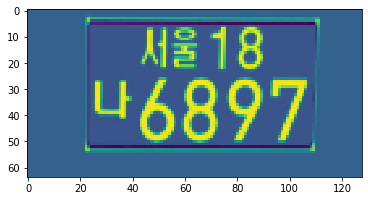

In [29]:
plt.imshow(tiger_train.imgs[0])

In [53]:
test_img, test_text = tiger_train.next_sample()

In [78]:
text_to_labels(test_text)

[19, 31, 37, 0, 6, 35, 40, 32, 36]

# Training

## [EarlyStopping](https://tykimos.github.io/2017/07/09/Early_Stopping/)
> 특정 조건을 만족하면 학습을 종료시키는 콜백 함수

```python
keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
```

## [fit_generator](https://tykimos.github.io/2017/03/08/CNN_Getting_Started/)
> 제너레이터로 생성된 배치를 학습할 떄 사용

- 제너레이터는 대용량의 학습데이터를 메모리에 다 로드해놓을 수 없으니 `yield`를 통해 한번씩 불러와서 학습시키기 위한 방법

### 인자
- 첫번째 인자 : 훈련데이터셋을 제공할 제네레이터를 지정
- steps_per_epoch : 한 epoch에 사용한 스텝 수를 지정합니다. 총 샘플 수 / batch
- epochs : 전체 훈련 데이터셋에 대해 학습 반복 횟수를 지정
- validation_data : 검증데이터셋을 제공할 제네레이터를 지정
- validation_steps : 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정 총 검증 샘플 수 / batch

In [5]:
from keras import backend as K
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
K.set_learning_phase(0)

# # Model description and training

model = get_Model(training=True)

try:
    model.load_weights('LSTM+BN4--26--0.011.hdf5')
    print("...Previous weight data...")
except:
    print("...New weight data...")
    pass

train_file_path = './DB/train/'
tiger_train = TextImageGenerator(train_file_path, img_w, img_h, batch_size, downsample_factor)
tiger_train.build_data()

valid_file_path = './DB/test/'
tiger_val = TextImageGenerator(valid_file_path, img_w, img_h, val_batch_size, downsample_factor)
tiger_val.build_data()

ada = Adadelta()
# loss의 변화량이 0.001보다 적으면 학습의 개선이 없다 판단하고 4 epoch만큼 지속되면 종료
early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=4, mode='min', verbose=1)
#checkpoint = ModelCheckpoint(filepath='LSTM+BN5--{epoch:02d}--{val_loss:.3f}.hdf5', monitor='loss', verbose=1, mode='min', period=1)
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=ada)

# generator로 생성된 배치로 학습할떄 fit_generator 사용
# 
model.fit_generator(generator=tiger_train.next_batch(),
                    steps_per_epoch=int(tiger_train.n / batch_size),
                    epochs=50,
                    #callbacks=[checkpoint],
                    validation_data=tiger_val.next_batch(),
                    validation_steps=int(tiger_val.n / val_batch_size))

Tensor("ctc_1/ExpandDims:0", shape=(?, 1), dtype=float32)
...New weight data...
5  Image Loading start...
True
5  Image Loading finish...
5  Image Loading start...
True
5  Image Loading finish...
Epoch 1/50
5/5 [==============================] - 9s 2s/step - loss: 84.3499 - val_loss: 85.2833
Epoch 2/50
5/5 [==============================] - 4s 764ms/step - loss: 55.2840 - val_loss: 37.0403
Epoch 3/50
5/5 [==============================] - 4s 787ms/step - loss: 40.2301 - val_loss: 44.7843
Epoch 4/50
5/5 [==============================] - 4s 783ms/step - loss: 40.7926 - val_loss: 36.4645
Epoch 5/50
5/5 [==============================] - 4s 783ms/step - loss: 39.7627 - val_loss: 34.5797
Epoch 6/50
5/5 [==============================] - 4s 779ms/step - loss: 38.3609 - val_loss: 33.6194
Epoch 7/50
5/5 [==============================] - 4s 768ms/step - loss: 36.0357 - val_loss: 36.7630
Epoch 8/50
5/5 [==============================] - 4s 766ms/step - loss: 31.0019 - val_loss: 35.8520
Epoch 9

## weight save

In [7]:
model.save_weights("./model.h5")

# Prediction

In [19]:
len(Hangul.keys())

37

In [6]:
import cv2
import itertools, os, time
import numpy as np
import argparse
from keras import backend as K
K.set_learning_phase(0)

Region = {"A": "서울 ", "B": "경기 ", "C": "인천 ", "D": "강원 ", "E": "충남 ", "F": "대전 ",
          "G": "충북 ", "H": "부산 ", "I": "울산 ", "J": "대구 ", "K": "경북 ", "L": "경남 ",
          "M": "전남 ", "N": "광주 ", "O": "전북 ", "P": "제주 "}
Hangul = {"dk": "아", "dj": "어", "dh": "오", "dn": "우", "qk": "바", "qj": "버", "qh": "보", "qn": "부",
          "ek": "다", "ej": "더", "eh": "도", "en": "두", "rk": "가", "rj": "거", "rh": "고", "rn": "구",
          "wk": "자", "wj": "저", "wh": "조", "wn": "주", "ak": "마", "aj": "머", "ah": "모", "an": "무",
          "sk": "나", "sj": "너", "sh": "노", "sn": "누", "fk": "라", "fj": "러", "fh": "로", "fn": "루",
          "tk": "사", "tj": "서", "th": "소", "tn": "수", "gj": "허"}

#
def decode_label(out):
    # out : (1, 32, 42)
    print(f'decode_label.. out.shape : {out.shape}')
    out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index -> len = 32
    print(f'decode_label.. out_best : {out_best}')
    print(f'decode_label.. out_best.shape : {len(out_best)}')
    out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
    print(f'decode_label..groupby.. out_best : {out_best}')
    outstr = ''
    for i in out_best:
        if i < len(letters):
            outstr += letters[i]
    print(f'decode_label..groupby.. outstr : {outstr}')
    return outstr


# A99th3954같은 형태의 label이 예측되게 되는데 각 label의 위치값으로 번호판 예측
def label_to_hangul(label):  # eng -> hangul
    region = label[0]
    two_num = label[1:3]
    hangul = label[3:5]
    four_num = label[5:]

    try:
        region = Region[region] if region != 'Z' else ''
    except:
        pass
    try:
        hangul = Hangul[hangul]
    except:
        pass
    return region + two_num + hangul + four_num

In [20]:

img = cv2.imread(test_dir + test_img, cv2.IMREAD_GRAYSCALE)

img_pred = img.astype(np.float32)
img_pred = cv2.resize(img_pred, (128, 64))
img_pred = (img_pred / 255.0) * 2.0 - 1.0
img_pred = img_pred.T
img_pred = np.expand_dims(img_pred, axis=-1)
img_pred = np.expand_dims(img_pred, axis=0)
# 1, 128, 64, 1
print(f'img_pred.shape : {img_pred.shape}')

net_out_value = model.predict(img_pred)
#pred_texts = decode_label(net_out_value)
out = net_out_value
print(f'decode_label.. out : {out}')
print(f'decode_label.. out.shape : {out.shape}')
out_best = list(np.argmax(out[0, 2:], axis=1))  # get max index -> len = 32
print(f'decode_label.. out_best : {out_best}')
print(f'decode_label.. out_best.shape : {len(out_best)}')
out_best = [k for k, g in itertools.groupby(out_best)]  # remove overlap value
print(f'decode_label..groupby.. out_best : {out_best}')
outstr = ''
for i in out_best:
    if i < len(letters):
        outstr += letters[i]

img_pred.shape : (1, 128, 64, 1)
decode_label.. out : [[[1.77545585e-02 1.27857365e-02 9.20890644e-03 ... 5.54262148e-03
   1.66375041e-02 6.79988414e-03]
  [4.97288909e-03 5.00057638e-03 3.98675771e-03 ... 3.63771780e-03
   1.46003896e-02 3.87180783e-03]
  [3.72951594e-03 2.44037411e-03 1.84131647e-03 ... 3.64507106e-03
   2.46913470e-02 7.23525370e-03]
  ...
  [4.31719382e-04 3.62156046e-04 3.15336918e-04 ... 2.65392270e-02
   6.38357937e-01 4.89093922e-03]
  [5.96296100e-04 5.41131012e-04 5.55351842e-04 ... 4.65710415e-03
   2.37670720e-01 3.31204222e-03]
  [1.06788299e-03 7.81709852e-04 1.28480012e-03 ... 2.46030930e-03
   1.69234216e-01 3.64623778e-03]]]
decode_label.. out.shape : (1, 32, 42)
decode_label.. out_best : [19, 31, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 39, 40, 36, 36]
decode_label.. out_best.shape : 30
decode_label..groupby.. out_best : [19, 31, 41, 39, 40, 36]


In [36]:
np.argmax(out[0, 2:], axis=1)

array([19, 31, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 39, 40, 36, 36], dtype=int64)

In [34]:
np.argmax(out[0, :], axis=1)

array([21, 19, 19, 31, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 39, 40, 36, 36],
      dtype=int64)

In [9]:
model = get_Model(training=False)

try:
    model.load_weights('model.h5')
    print("...Previous weight data...")
except:
    raise Exception("No weight file!")

test_dir = './DB/test/'
test_imgs = os.listdir(test_dir)
total = 0
acc = 0
letter_total = 0
letter_acc = 0
start = time.time()


for test_img in test_imgs:
    img = cv2.imread(test_dir + test_img, cv2.IMREAD_GRAYSCALE)

    img_pred = img.astype(np.float32)
    img_pred = cv2.resize(img_pred, (128, 64))
    img_pred = (img_pred / 255.0) * 2.0 - 1.0
    img_pred = img_pred.T
    img_pred = np.expand_dims(img_pred, axis=-1)
    img_pred = np.expand_dims(img_pred, axis=0)
    # 1, 128, 64, 1
    print(f'img_pred.shape : {img_pred.shape}')

    net_out_value = model.predict(img_pred)

    pred_texts = decode_label(net_out_value)
    print(f'net_out_value.shape : {net_out_value.shape} pred_texts : {pred_texts}')
    
          
    for i in range(min(len(pred_texts), len(test_img[0:-4]))):
        if pred_texts[i] == test_img[i]:
            letter_acc += 1
    letter_total += max(len(pred_texts), len(test_img[0:-4]))

    if pred_texts == test_img[0:-4]:
        acc += 1
    total += 1
    print('Predicted: %s  /  True: %s' % (label_to_hangul(pred_texts), label_to_hangul(test_img[0:-4])))
    
    # cv2.rectangle(img, (0,0), (150, 30), (0,0,0), -1)
    # cv2.putText(img, pred_texts, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255),2)

    #cv2.imshow("q", img)
    #if cv2.waitKey(0) == 27:
    #   break
    #cv2.destroyAllWindows()

end = time.time()
total_time = (end - start)
print("Time : ",total_time / total)
print("ACC : ", acc / total)
print("letter ACC : ", letter_acc / letter_total)

Tensor("ctc_3/ExpandDims:0", shape=(?, 1), dtype=float32)
...Previous weight data...
img_pred.shape : (1, 128, 64, 1)
decode_label.. out.shape : (1, 32, 42)
decode_label.. out_best : [20, 32, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 39, 39, 33, 35, 35]
decode_label.. out_best.shape : 30
decode_label..groupby.. out_best : [20, 32, 41, 39, 33, 35]
decode_label..groupby.. outstr : G1824
net_out_value.shape : (1, 32, 42) pred_texts : G1824
Predicted: 충북 1824  /  True: 부산 99우8954
img_pred.shape : (1, 128, 64, 1)
decode_label.. out.shape : (1, 32, 42)
decode_label.. out_best : [20, 32, 32, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 39, 39, 33, 35, 35]
decode_label.. out_best.shape : 30
decode_label..groupby.. out_best : [20, 32, 41, 39, 33, 35]
decode_label..groupby.. outstr : G1824
net_out_value.shape : (1, 32, 42) pred_texts : G1824
Predicted: 충북 1824  /  True: 경남 37마0112
img_pred.shape : (1, 12

In [ ]:
test_img = test_imgs[0]
img = cv2.imread(test_dir + test_img, cv2.IMREAD_GRAYSCALE)

img_pred = img.astype(np.float32)
img_pred = cv2.resize(img_pred, (128, 64))
img_pred = (img_pred / 255.0) * 2.0 - 1.0
print(img_pred.shape)
img_pred = img_pred.T
img_pred = np.expand_dims(img_pred, axis=-1)
img_pred = np.expand_dims(img_pred, axis=0)
print(f'img_pred.shape : {img_pred.shape}')

net_out_value = model.predict(img_pred)

pred_texts = decode_label(net_out_value)
print(f'net_out_value.shape : {net_out_value.shape}')
print(f'pred_texts : {pred_texts}')
